<a href="https://colab.research.google.com/github/pranitha-pedapudi/IIIT_FMML/blob/main/FMML_M2_L4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 2: Appreciating, Interpreting and Visualizing Data
## Lab 4: t-Distributed Stochastic Neighbor Embedding (t-SNE)

t-SNE has a tuneable parameter, **perplexity** which balances attention between the local and global aspects of your data. It is a guess about the number of close neighbors each point has. The perplexity value has a complex effect on the resulting pictures. The original paper says, “The performance of t-SNE is fairly robust to changes in the perplexity, and typical values are between 5 and 50.” But the story is more nuanced than that. Getting the most from t-SNE may mean analyzing multiple plots with different perplexities.

Also the t-SNE algorithm doesn’t always produce similar output on successive runs as there are additional hyperparameters related to the optimization process.

### HOW DOES T-SNE WORK??

The t-SNE algorithm calculates a similarity measure between pairs of instances in the high dimensional space and in the low dimensional space. It then tries to optimize these two similarity measures using a cost function. Let’s break that down into 3 basic steps.

1. Measure similarities between points in the high dimensional space. Think of a bunch of data points scattered on a 2D space. For each data point (xi) we’ll center a Gaussian distribution over that point. Then we measure the density of all points (xj) under that Gaussian distribution. Then renormalize for all points. This gives us a set of probabilities (Pij) for all points. Those probabilities are proportional to the similarities. All that means is, if data points x1 and x2 have equal values under this gaussian circle then their proportions and similarities are equal and hence you have local similarities in the structure of this high-dimensional space. The Gaussian distribution or circle can be manipulated using what’s called perplexity, which influences the variance of the distribution (circle size) and essentially the number of nearest neighbors.

2. This step is similar to step 1, but instead of using a Gaussian distribution we use a Student t-distribution with one degree of freedom, which is also known as the Cauchy distribution (See fig below). This gives us a second set of probabilities (Qij) in the low dimensional space. As you can see the Student t-distribution has heavier tails than the normal distribution. The heavy tails allow for better modeling of far apart distances.

3. The last step is that we want these set of probabilities from the low-dimensional space (Qij) to reflect those of the high dimensional space (Pij) as best as possible. We want the two map structures to be similar. We measure the difference between the probability distributions of the two-dimensional spaces using Kullback-Liebler divergence (KL). Finally, we use gradient descent to minimize our KL cost function.

Scikit-learn has an implementation of t-SNE available which provides a wide variety of tuning parameters for t-SNE, and the most notable ones are:

1. n_components (default: 2): Dimension of the embedded space.
2. perplexity (default: 30): The perplexity is related to the number of nearest neighbors that are used in other manifold learning algorithms. Consider selecting a value between 5 and 50.
3. n_iter (default: 1000): Maximum number of iterations for the optimization. Should be at least 250.
4. method (default: ‘barnes_hut’): Barnes-Hut approximation runs in O(NlogN) time. method=’exact’ will run on the slower, but exact, algorithm in O(N^2) time.

In [ ]:
# numpy.
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# Random state.
RS = 20150101

# matplotlib.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# seaborn.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [ ]:
digits = load_digits()
digits.data.shape

(1797, 64)

Printing some images from the dataset

---

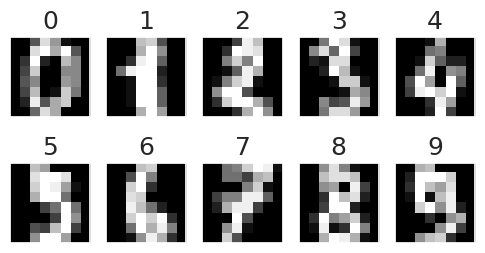

In [ ]:
nrows, ncols = 2, 5
plt.figure(figsize=(6,3))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])

In [ ]:
# We first reorder the data points according to the handwritten numbers.
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])

## Now using TSNE to fit the dataset with the default values.


1. n_components : 2
2. perplexity : 30
3. n_iter : 1000
4. method : ‘barnes_hut’


---

In [ ]:
digits_proj = TSNE(init="pca", random_state=RS).fit_transform(X)

#### Visualizing the data in the projected space

---


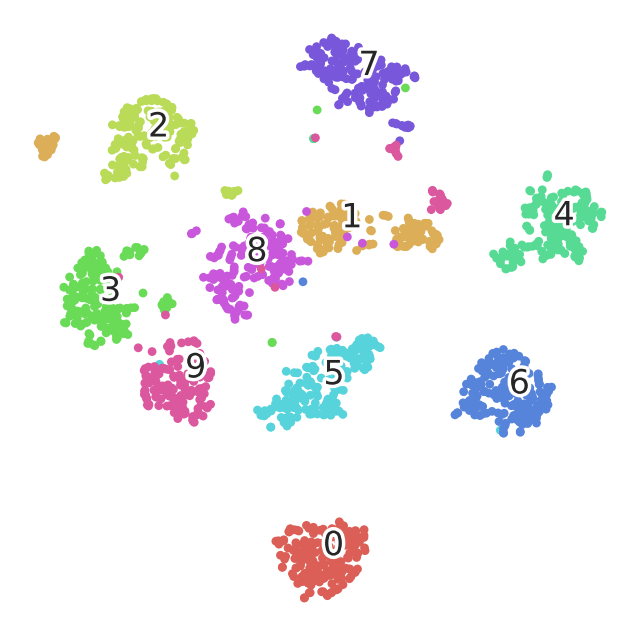

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x781a96950b50>)

In [ ]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    plt.show()

    return f, ax, sc

scatter(digits_proj, y)

# Tweaking some of the hyperparameters to better understand their role

---

### Changing the PERPLEXITY values

With perplexity values in the range (5 - 50) suggested by van der Maaten & Hinton, the diagrams do show these clusters, although with very different shapes. Outside that range, things get a little weird. With perplexity 2, local variations dominate. The image for perplexity 100, with merged clusters, illustrates a pitfall: for the algorithm to operate properly, the perplexity really should be smaller than the number of points. Implementations can give unexpected behavior otherwise.

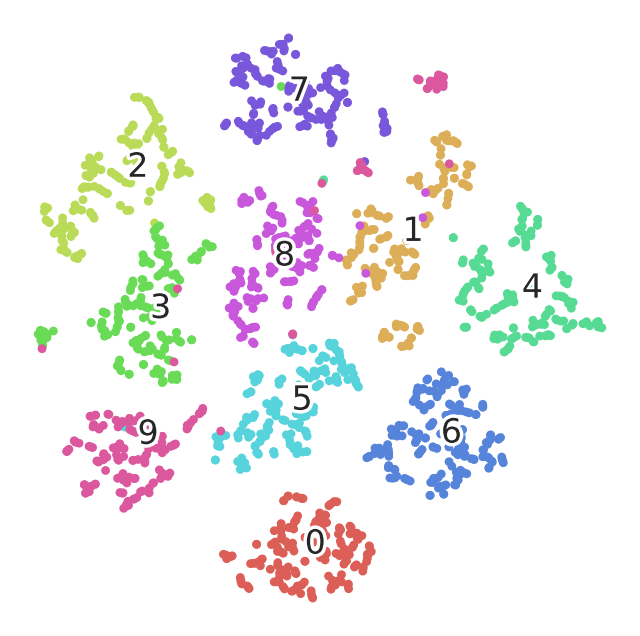

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x781a991fa440>)

In [ ]:
digits_proj = TSNE(init="pca", random_state=RS, perplexity=5).fit_transform(X)

scatter(digits_proj, y)

We can see that there are local clusters within the same number group as well. This is happening as the perplexity being at 5, allows the local neighbourhood to dominate. Let us now see what happens if we increase the perplexity to 100, thereby increasing global impact.




---


1. n_components : 2
2. perplexity : **100**
3. n_iter : 1000
4. method : ‘barnes_hut’


---

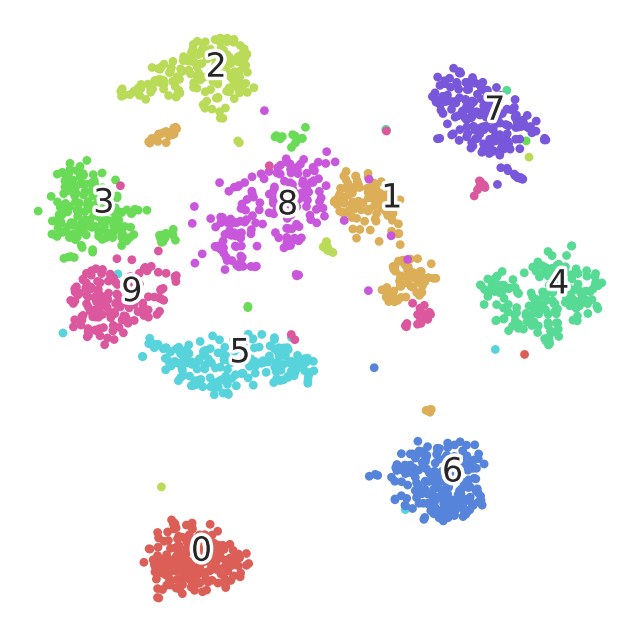

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x781a9904f820>)

In [ ]:
digits_proj = TSNE(init="pca", random_state=RS, perplexity=100).fit_transform(X)

scatter(digits_proj, y)

The general structure of the plot remained similar to the one with perplexity = 30 (default), but on careful observation you can observe many data points not being part of the group they are supposed to be in. This is because of the large number of points considered for the neighbourhood (as perplexity value = 100 is higher), thereby allowing 2 data points from different groups to end up closer.



---

### Changing the NUMBER OF ITERATIONS

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


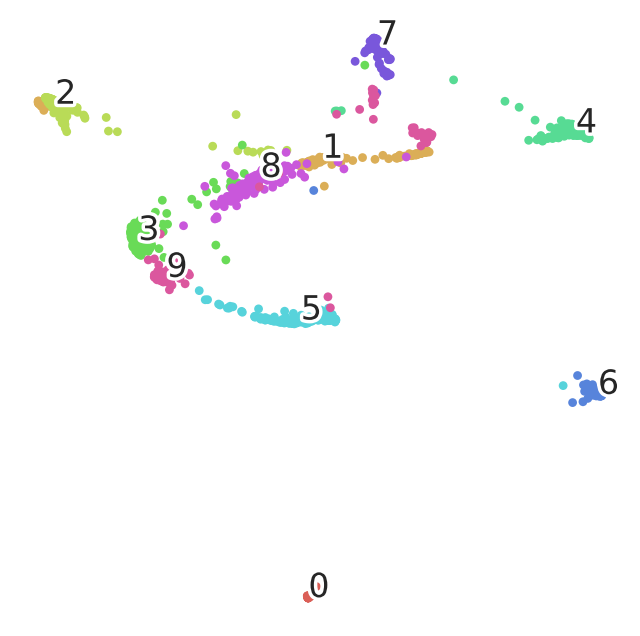

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x781a99594640>)

In [ ]:
digits_proj = TSNE(init="pca", random_state=RS, n_iter=250).fit_transform(X)

scatter(digits_proj, y)

As can be seen from the figure above, stopping the optimization earlier (in 250 iterations) resulted in a suboptimal clustering of the groups.

Let us now see how the results are affected if t-SNE is run for larger number of iterations


---


1. n_components : 2
2. perplexity : 30
3. n_iter : **5000**
4. method : ‘barnes_hut’


---

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


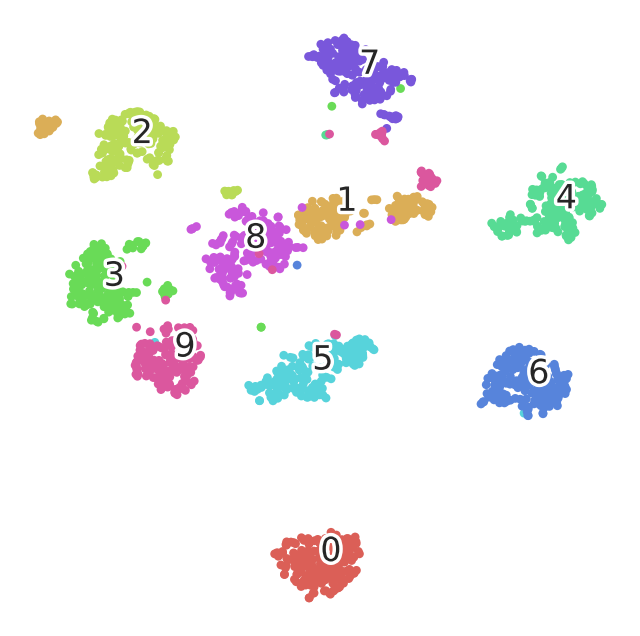

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x781a98eb95a0>)

In [ ]:
digits_proj = TSNE(init="pca", random_state=RS, n_iter=5000).fit_transform(X)

scatter(digits_proj, y)

Running for larger number of iterations more or less resulted in the same plot as the optimization had nearly converged till the default 1000 iterations. However the density of the clusters has increased.

---

### Changing the method to EXACT

The barnes-hut method takes O(NlogN) time, whereas the exact method takes O(N^2) time. Notice the increase in the execution time while running the cell below.


---

1. n_components : 2
2. perplexity : 30
3. n_iter : 1000
4. method : **‘exact’**


---

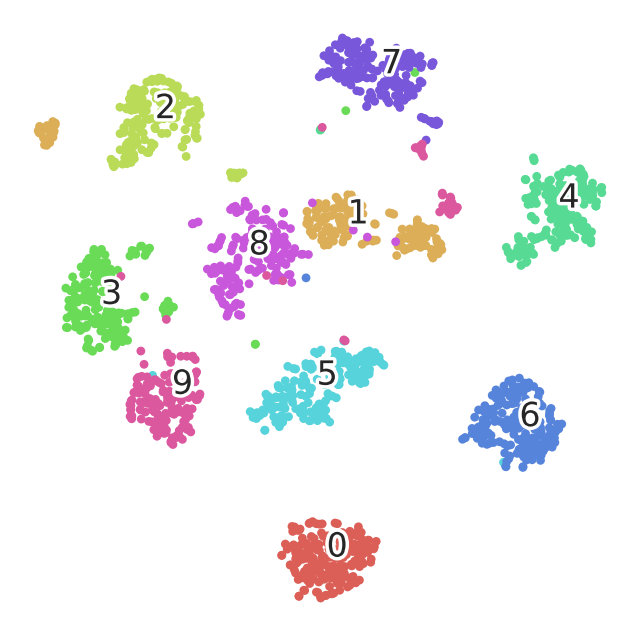

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x781a96920af0>)

In [ ]:
digits_proj = TSNE(init="pca", random_state=RS, method='exact').fit_transform(X)

scatter(digits_proj, y)

## EXERCISE

---



Try out different perplexity and iteration values to better appreciate the concepts taught.

You can modify the code in the cell below to check the resultant plots.

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


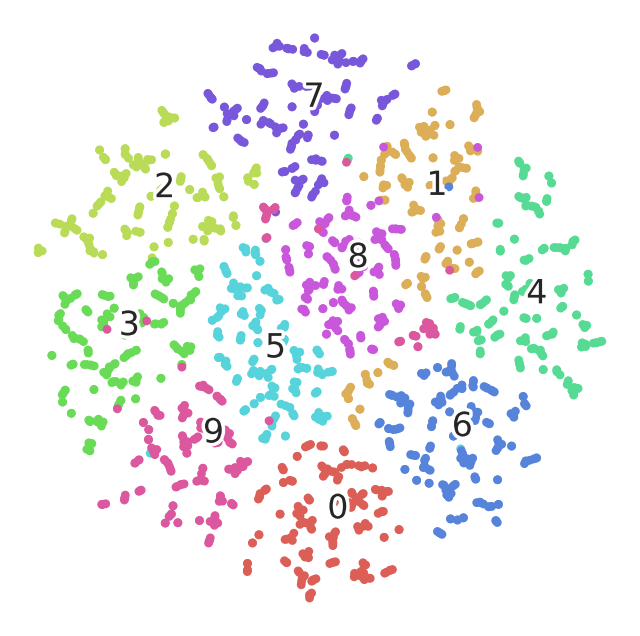

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x781a92e2d990>)

In [ ]:
###############################################################
###### MODIFY THE VALUES FOR THE HYPERPARAMETERS BELOW ########

perplexity_value = 2
number_iterations = 1000
method = "barnes_hut"

###############################################################

digits_proj = TSNE(init="pca", random_state=RS, n_iter=number_iterations, perplexity=perplexity_value, method=method).fit_transform(X)
scatter(digits_proj, y)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


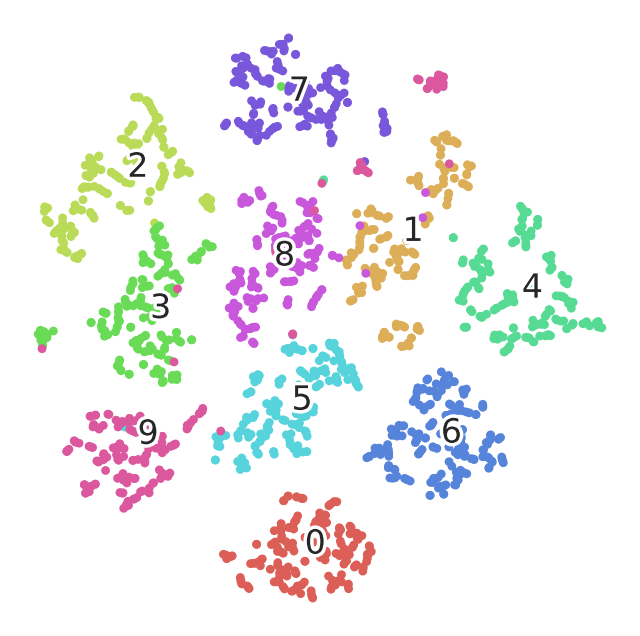

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


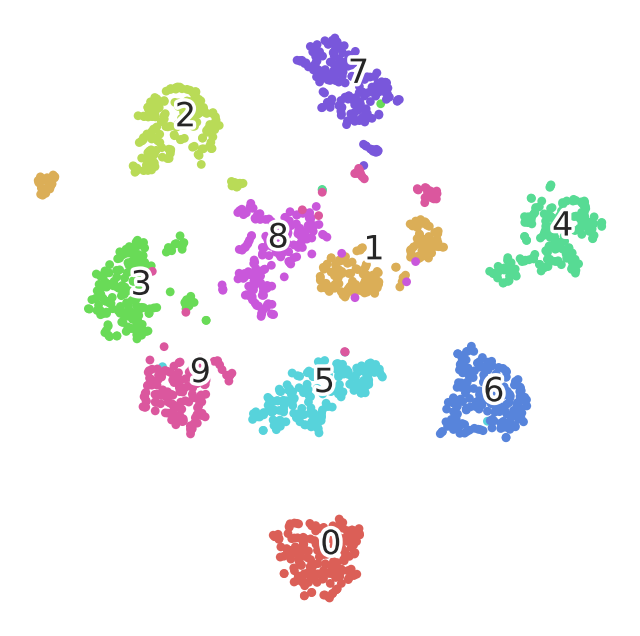

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


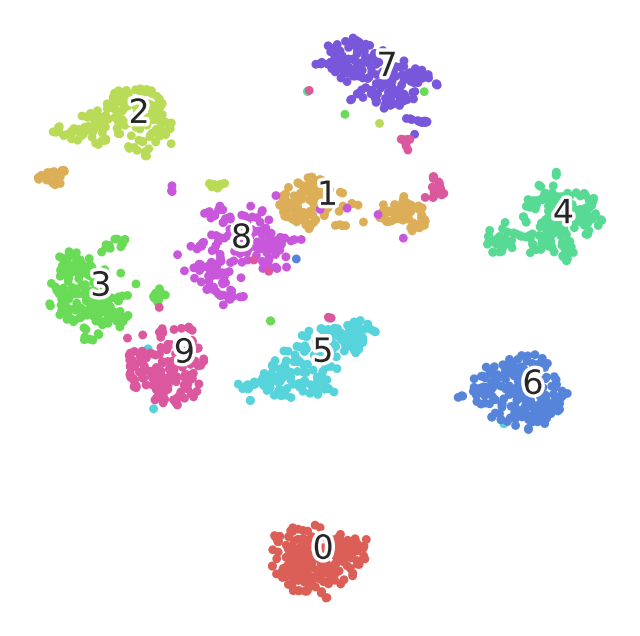

In [ ]:
# EXERCISE
# Varying perplexity
perplexity_values = [5, 20, 50]
number_iterations = 1000

for perplexity_value in perplexity_values:
    digits_proj = TSNE(init="pca", random_state=RS, n_iter=number_iterations, perplexity=perplexity_value).fit_transform(X)
    scatter(digits_proj, y)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


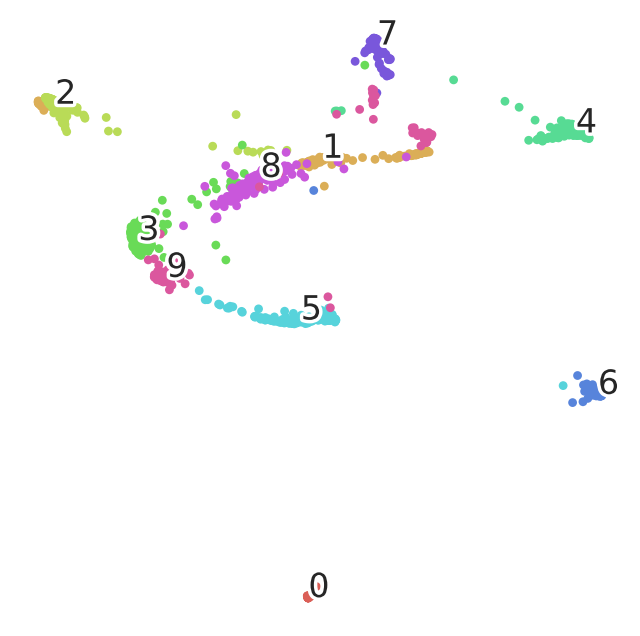

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


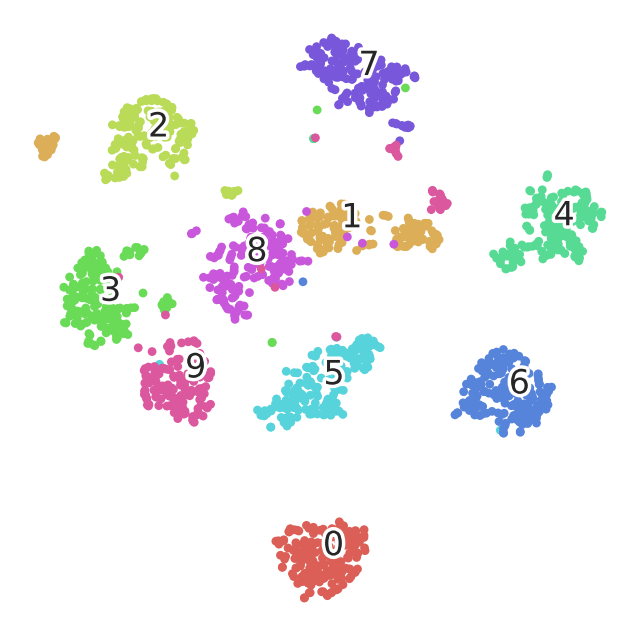

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


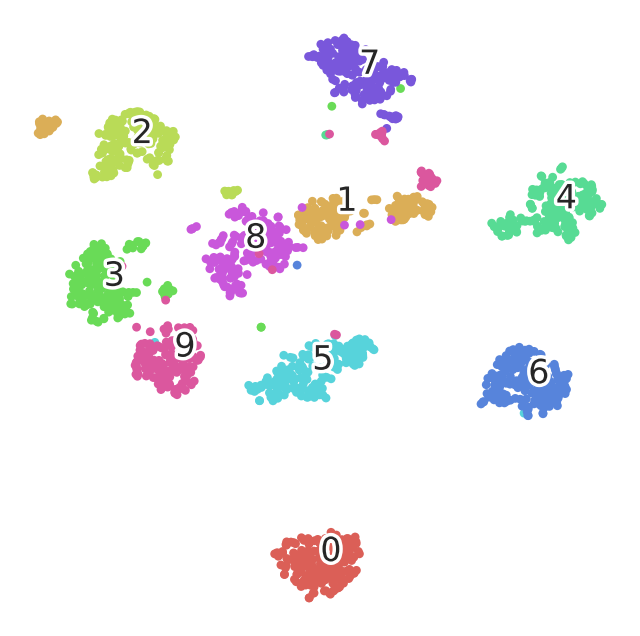

In [ ]:
# EXERCISE
# Iteration
perplexity_value = 30
iteration_values = [250, 1000, 5000]

for number_iterations in iteration_values:
    digits_proj = TSNE(init="pca", random_state=RS, n_iter=number_iterations, perplexity=perplexity_value).fit_transform(X)
    scatter(digits_proj, y)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


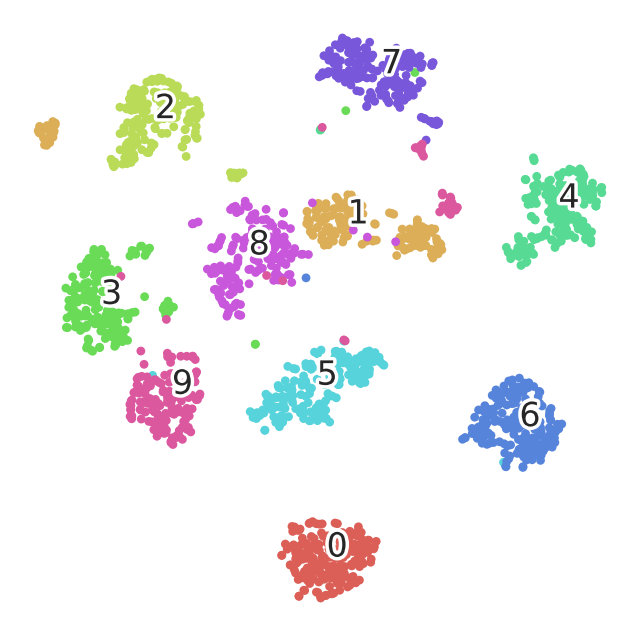

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


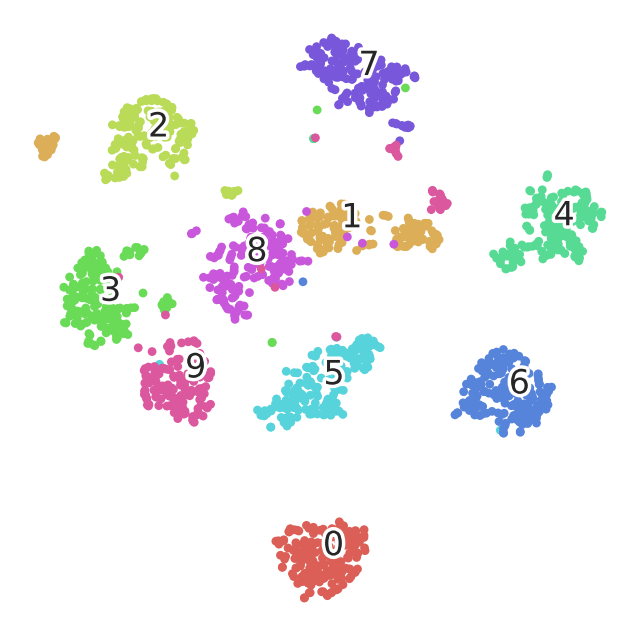

In [ ]:
# EXERCISE
# Comparison of 'exact' and 'barnes_hut' Methods
perplexity_value = 30
number_iterations = 1000

methods = ['exact', 'barnes_hut']

for method in methods:
    digits_proj = TSNE(init="pca", random_state=RS, n_iter=number_iterations, perplexity=perplexity_value, method=method).fit_transform(X)
    scatter(digits_proj, y)




---

## QUESTION:

Now that you understand t-SNE a bit better, can you point out some differences between PCA and t-SNE. What are the advantages/disadvantages of one over the other?


##### Pointers:

1. Which of the two algorithms is linear and which one is non-linear?
2. How does the non-linearity in one of these two algorithms help in capturing certain data sets?
3. PCA is known to keep points which were further apart in the higher dimension, far apart in the lower dimension as well. Does t-SNE do the same? Or does it try to preserve local neighbourhood?
4. Can you comment on which one of the two is computationally more expensive?


# **ANSWERS TO THE QUESTIONS**
# **PCA:**

1.   ***Linear algorithm:*** PCA is a linear method that finds the directions (principal components) in the data that capture the most variance.
2.   Emphasizes global structure in data: It primarily focuses on the overall structure of the data by preserving the directions with maximum variance.
3.   Keeps distant points far apart in lower dimensions: PCA attempts to maintain the relative distances between data points in the high-dimensional space, trying to keep distant points similarly far apart in the lower-dimensional space.
4.  ***Computationally less expensive:*** It is relatively faster and less computationally intensive compared to t-SNE, making it more suitable for larger datasets.
Useful for noise reduction and feature selection: PCA can be used to denoise data and select the most informative features.
5.  May not capture complex, non-linear structures effectively: Being a linear technique, PCA might not represent complex non-linear relationships well, especially in high-dimensional data.



---



# **t-SNE:**

1.  ***Non-linear algorithm***: t-SNE is a non-linear technique used for data visualization, focusing on capturing local structures in the data.
2.  Focuses on preserving local relationships: It emphasizes the preservation of local relationships between data points in the lower-dimensional space.
3.  Tries to maintain local neighborhoods in lower dimensions: It aims to keep nearby points close together in the lower-dimensional space, giving importance to local structures over global ones.
4.  ***Computationally more expensive:*** t-SNE is more computationally demanding, particularly for larger datasets due to its complexity, which could limit its use for very large datasets.
5.  Great for visualizing complex, non-linear structures: Ideal for visualization and understanding complex, non-linear relationships in data, making it useful for exploratory data analysis.
6.  
It might not effectively preserve global distances as its primary focus is on local structures.

# **Answers to pointers**

**Q1 Ans -** PCA is a linear algorithm, while t-SNE is a non-linear algorithm.


---



**Q2 Ans -** The non-linearity in t-SNE, excels in capturing intricate, non-linear relationships within complex high-dimensional datasets.By emphasizing local relationships and structures, t-SNE provides a detailed view of the data, revealing subtle patterns and clusters, particularly beneficial for exploring and understanding local interdependencies among data points. This unique feature allows for a more in-depth analysis of the immediate connections between data points.


---



**Q3 Ans -** PCA aims to keep distant points similarly distant in lower dimensions. In contrast, t-SNE prioritizes the preservation of local structures and relationships, attempting to keep nearby points close together in the lower-dimensional space.


---



**Q4 Ans -** SNE is computationally more expensive compared to PCA due to its non-linear nature and the emphasis on local relationships, making it more demanding for larger datasets.